In [16]:
import torch
from torchvision import models
import torchvision.transforms as transforms
import skimage
import numpy as np

In [2]:
from transformers.tf_exp import ImageLoader

In [3]:
nature_loader = ImageLoader('../../Datasets/imagenette2/train/n01440764')
syn_loader = ImageLoader('./results/evolutions/vit_b_16/tench')

In [4]:
nature_loader.load()
syn_loader.load()

100%|██████████| 3/3 [00:00<00:00, 200.99it/s]


3

In [5]:
natural_images = nature_loader.imgs
generated_images = syn_loader.imgs

In [10]:
natural_images.shape

torch.Size([963, 3, 224, 224])

In [17]:
# Preprocess the generated image and natural images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
generated_images = [transform(image.squeeze().permute((1, 2, 0)).numpy().astype(np.uint8)) for image in generated_images]  # Apply preprocessing to generated image
natural_images = [transform(image.squeeze().permute((1, 2, 0)).numpy().astype(np.uint8)) for image in natural_images]  # Apply preprocessing to natural images

In [20]:
generated_images

torch.Size([3, 227, 227])

In [21]:
# Load the AlexNet model and extract activation vectors
alexnet = models.alexnet(pretrained=True)
alexnet.eval()
with torch.no_grad():
    generated_vectors = [alexnet(image.unsqueeze(0))[0] for image in generated_images]  # Extract activation vector for generated image
    natural_vectors = [alexnet(image.unsqueeze(0))[0] for image in natural_images]  # Extract activation vectors for natural images

/home/paperspace/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paperspace/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Calculate distance between generated vector and natural vectors
distances = [torch.norm(generated_vectors[0] - vector).item() for vector in natural_vectors]

# Select the closest natural images
num_closest = 5  # Number of closest images to select
closest_indices = torch.argsort(torch.tensor(distances))[:num_closest]
closest_images = [natural_images[i] for i in closest_indices]

In [28]:
closest_images[0].shape

torch.Size([3, 227, 227])

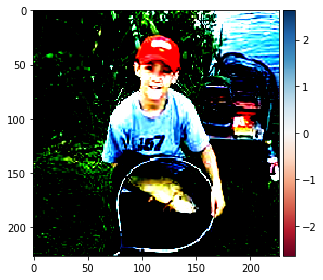

In [29]:
skimage.io.imshow(closest_images[0].permute((1, 2, 0)).numpy())